# LSTM 

Implementation based on code from notebook: 1. Encoder-Decoder Seq2Seq.ipynb

In [71]:
import re, torch, pickle, json
from torch.utils.data import DataLoader, TensorDataset
import nltk
import numpy as np
import time

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check the available device
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed_all(SEED)
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

# Load the datasets
with open("data/train.pkl", "rb") as f:
    train = pickle.load(f)
with open("data/val.pkl", "rb") as f:
    val = pickle.load(f)
with open("data/test.pkl", "rb") as f:
    test = pickle.load(f)

# Remap original labels {0,4} -> contiguous ids {0,1} for modeling
# (Keep a copy of the original labels for reporting/debugging.)
LABEL_MAP = {0: 0, 4: 1}

for df_name, df in [("train", train), ("val", val), ("test", test)]:
    df["label_original"] = df["label"]
    mapped = df["label_original"].map(LABEL_MAP)

    df["label"] = mapped.astype(int)

num_labels = train["label"].nunique()
print("Number of labels (label): ", num_labels)

# With remapping, class ids are stable
label_0 = 0  # Negative
label_4 = 1  # Positive
print(f"Label 0: {label_0} and label 4: {label_4}")

train.head(2)

Using device: mps
Number of labels (label):  2
Label 0: 0 and label 4: 1


,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet,label,label_original
237034,0,2058468667,Sat Jun 06 15:00:18 PDT 2009,NO_QUERY,bestthingaround,my star trek bootleg timed out and when i refr...,0,0
1387008,0,2068651245,Sun Jun 07 14:27:20 PDT 2009,NO_QUERY,Scriblit,yeah but the really pretty ones only go up to ...,0,0


# Text Preprocessing and Vocabulary Building

In [ ]:
# ---------------------------------------
# Text Preprocessing and Vocabulary Building
# ---------------------------------------

from collections import Counter

# Function to tokenize text (same as in RNN notebook)
def preprocess_text(text):
    """Convert text to lowercase tokens."""
    if not isinstance(text, str):
        return []
    # Keep only letters and whitespaces
    text = re.sub(r"[^a-zA-Z\s]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    # Tokenize using NLTK
    tokens = nltk.word_tokenize(text)
    return tokens

# Tokenize all datasets
print("Tokenizing datasets...")
train['tokens'] = train['text of the tweet'].apply(preprocess_text)
val['tokens'] = val['text of the tweet'].apply(preprocess_text)
test['tokens'] = test['text of the tweet'].apply(preprocess_text)

# Build vocabulary from training data only
print("Building vocabulary from training data...")
all_tokens = [token for tokens in train['tokens'] for token in tokens]
word_counts = Counter(all_tokens)

# Filter words that appear at least min_count times
min_count = 2  # Words must appear at least 2 times
repeated_n = 4  # Number of repeated characters to filter out

def has_repeated_chars(word, n):
    return any(all(word[i+j] == word[i] for j in range(n)) for i in range(len(word) - n + 1))

filtered_words = [
    word for word, count in word_counts.items()
    if count >= min_count and not has_repeated_chars(word, repeated_n)
]

# Create vocabulary dictionary
# Special tokens: <PAD>=0 (padding), <UNK>=1 (unknown words)
vocab = {'<PAD>': 0, '<UNK>': 1}
# Add all words starting from index 2
for idx, word in enumerate(sorted(filtered_words), start=2):
    vocab[word] = idx

# Create reverse mapping (index -> word)
idx_to_word = {idx: word for word, idx in vocab.items()}

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size:,}")
print(f"  - Special tokens: 2 (<PAD>, <UNK>)")
print(f"  - Unique words (min_count={min_count}): {vocab_size - 2:,}")
print(f"  - Total unique words in training data: {len(word_counts):,}")

# Show some example words
print(f"\nSample vocabulary entries:")
for i, (word, idx) in enumerate(list(vocab.items())[:10]):
    print(f"  '{word}': {idx}")

# Function to convert tokens to indices
def tokens_to_indices(tokens, vocab, max_length=None):
    """Convert list of tokens to list of indices."""
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if max_length:
        # Truncate or pad to max_length
        if len(indices) > max_length:
            indices = indices[:max_length]
        else:
            indices = indices + [vocab['<PAD>']] * (max_length - len(indices))
    return indices


max_seq_length = 100  # Same as in the notebook Encoder-Decoder Seq2Seq.ipynb (MAX_LENGTH_INPUT = 100)

print(f"\nMaximum sequence length: {max_seq_length}")

# Convert all datasets to sequences of indices
print("Converting text to sequences of indices...")
train['sequences'] = train['tokens'].apply(
    lambda tokens: tokens_to_indices(tokens, vocab, max_seq_length)
)
val['sequences'] = val['tokens'].apply(
    lambda tokens: tokens_to_indices(tokens, vocab, max_seq_length)
)
test['sequences'] = test['tokens'].apply(
    lambda tokens: tokens_to_indices(tokens, vocab, max_seq_length)
)

print("✅ Vocabulary and tokenization complete!")
print(f"\nExample sequence (first 20 indices):")
print(train['sequences'].iloc[0][:20])
print(f"Decoded: {[idx_to_word[idx] for idx in train['sequences'].iloc[0][:20]]}")

# Save token-ids dictionary
with open('tokens2ids.json', 'w') as f:
    json.dump(vocab,f,indent=2)
with open('ids2tokens.json', 'w') as f:
    json.dump(idx_to_word,f,indent=2)

Tokenizing datasets...
Building vocabulary from training data...
Vocabulary size: 119,294
  - Special tokens: 2 (<PAD>, <UNK>)
  - Unique words (min_count=2): 119,292
  - Total unique words in training data: 256,064

Sample vocabulary entries:
  '<PAD>': 0
  '<UNK>': 1
  'a': 2
  'aa': 3
  'aaa': 4
  'aaages': 5
  'aaagh': 6
  'aaah': 7
  'aaahahaha': 8
  'aaahgood': 9

Maximum sequence length: 100
Converting text to sequences of indices...
✅ Vocabulary and tokenization complete!

Example sequence (first 20 indices):
[66421, 97238, 106388, 11811, 103991, 72441, 3626, 114417, 47032, 85217, 102618, 73232, 49842, 88680, 83267, 85757, 28303, 104586, 1, 35111]
Decoded: ['my', 'star', 'trek', 'bootleg', 'timed', 'out', 'and', 'when', 'i', 'refreshed', 'the', 'page', 'it', 'said', 'quotvideo', 'removed', 'due', 'to', '<UNK>', 'fml']


# LSTM Encoder 

In [65]:
import torch.nn as nn
from torch import optim
class BiLSTM_Classifier(nn.Module):
    """
    A Bidirectional LSTM-based module designed for sequence encoding
    and subsequent sentiment classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_labels, dropout_p=0.1):
        super(BiLSTM_Classifier, self).__init__()
        
        # --- Parameters ---
        self.hidden_size = hidden_size
        self.num_classes = num_labels
        self.num_directions = 2 # Fixed for BiLSTM

        # --- Embedding Layer ---
        # input: (batch_size, seq_len) -> indices of tokens
        # output: (batch_size, seq_len, embedding_dim) -> dense word vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # --- Dropout Layer ---
        # Applied after embedding to regularize word vectors (Embedding Dropout)
        self.dropout = nn.Dropout(dropout_p)
        
        # --- BiLSTM Layer ---
        # input_size: embedding_dim (the size of the input features per time step)
        # hidden_size: hidden_size (the output size of the hidden state for ONE direction)
        # batch_first=True: input shape is (batch_size, seq_len, features)
        # bidirectional=True: output_dim = 2 * hidden_size
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        
        # --- Classification Layer (MLP) ---
        # The BiLSTM combines the final forward and backward hidden states.
        # Input size to the Linear layer must be (2 * hidden_size)
        # Output size is num_labels (e.g., 2 for positive/negative)
        self.classifier = nn.Linear(self.num_directions * hidden_size, num_labels)

    def forward(self, input_tensor):
        # 1. Embedding
        # shape: (bs, seq_len) -> (bs, seq_len, embedding_dim)
        embedded = self.dropout(self.embedding(input_tensor))
    
        # 2. BiLSTM Processing
        # output: (bs, seq_len, 2 * hidden_size) - full sequence output
        # (hidden, cell): state from both directions, shape: (2, bs, hidden_size)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # 3. Aggregate Hidden States for Classification
        # Reshape hidden to (num_directions, batch_size, hidden_size)
        hidden = hidden.view(self.num_directions, -1, self.hidden_size)
        
        # Concatenate forward (hidden[-2]) and backward (hidden[-1]) final states
        final_hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        
        # 4. Final Classification
        # input: (bs, 2 * hidden_size)
        # output: (bs, num_classes)
        prediction_logits = self.classifier(final_hidden)
        # For sentiment classification, we only need the final prediction
        return prediction_logits


# Define hyperparameters
embedding_dim = 128  # same as in notebook: 1. Encoder-Decoder Seq2Seq.ipynb
hidden_size = 128    # Common values: 64, 128, 256 - maybe decrease if training is too slow
learning_rate = 0.001
num_epochs = 30
batch_size = 64

print(f"Model hyperparameters:")
print(f"  vocab_size: {vocab_size:,}")
print(f"  embedding_dim: {embedding_dim}")
print(f"  hidden_size: {hidden_size}")
print(f"  num_labels: {num_labels}")



model =  BiLSTM_Classifier(
    vocab_size = vocab_size, 
    embedding_dim=embedding_dim,
    hidden_size=hidden_size, 
    num_labels=num_labels
).to(device)

# Use CrossEntropyLoss for multi-class classification (2 classes: negative=0, positive=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Print the number of trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Model hyperparameters:
  vocab_size: 119,294
  embedding_dim: 128
  hidden_size: 128
  num_labels: 2
Number of trainable parameters: 15534338


In [61]:
# ---------------------------------------
# Prepare DataLoaders
# ---------------------------------------

# Convert sequences and labels to tensors
X_train = torch.tensor(train['sequences'].tolist(), dtype=torch.long)
y_train = torch.tensor(train['label'].values, dtype=torch.long)

X_val = torch.tensor(val['sequences'].tolist(), dtype=torch.long)
y_val = torch.tensor(val['label'].values, dtype=torch.long)

X_test = torch.tensor(test['sequences'].tolist(), dtype=torch.long)
y_test = torch.tensor(test['label'].values, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 18000
Val batches: 4500
Test batches: 2500


In [ ]:
# Create mini versions of the train and val datasets (first 5 examples)
# mini_train = train[:5]
# mini_val = val[:5]

# X_train_mini = torch.tensor(mini_train['sequences'].tolist(), dtype=torch.long)
# y_train_mini = torch.tensor(mini_train['label'].values, dtype=torch.long)

# X_val_mini = torch.tensor(mini_val['sequences'].tolist(), dtype=torch.long)
# y_val_mini = torch.tensor(mini_val['label'].values, dtype=torch.long)

# mini_train_dataset = TensorDataset(X_train_mini, y_train_mini)
# mini_val_dataset = TensorDataset(X_val_mini, y_val_mini)

# mini_train_loader = DataLoader(mini_train_dataset, batch_size=batch_size, shuffle=True)
# mini_val_loader = DataLoader(mini_val_dataset, batch_size=batch_size, shuffle=False)

# print(f"MINI - Train batches: {len(mini_train_loader)}")
# print(f"MINI - Val batches: {len(mini_val_loader)}")

MINI - Train batches: 1
MINI - Val batches: 1


# Training Loop

In [ ]:
losses = []
val_losses = []

best_val_loss = float("inf")
best_epoch = 0
patience = 0
max_patience = 3

# Start timing training
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    count = 0
    for inputs, labels in train_loader:
        # inputs.shape = [bs, max_seq_len]
        inputs = inputs.to(device)
        # labels.shape = [bs]
        labels = labels.to(device)

        optimizer.zero_grad()
        # logits.shape: [batch_size, num_labels]
        logits = model(inputs)  
        #print("logit shape: ", logits.shape)
        # loss.shape: [batch_size] with class indices
        loss = criterion(logits, labels)  
        #print('loss shape: ', loss.shape)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        count += 1
    
    average_loss = total_loss / max(count, 1)
    losses.append(average_loss)


    model.eval()
    total_val_loss = 0.0
    val_count = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)  # Shape: [batch_size, 2]
            val_loss = criterion(logits, labels)  # labels: [batch_size] with class indices

            total_val_loss += float(val_loss.item())
            val_count += 1

    average_val_loss = total_val_loss / max(val_count, 1)
    val_losses.append(average_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}")

    # Save best checkpoint
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "lstm_best_model.pth")
        patience = 0
    else:
        patience += 1

    if patience >= max_patience:
        print(f"Early stopped at {epoch+1}")
        break


# Calculate total training time
training_time = time.time() - start_time
print(f"Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}")
print(f"Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Epoch 1/1, Loss: 0.7157, Val Loss: 0.6970
Lowest Validation Loss: 0.6970 at Epoch 1
Total Training Time: 29.22 seconds (0.49 minutes)


# Evaluation

## Evaluation Functions - Accuracy, Label Precision, Recall, F1, and Confusion Matric

In [68]:
from metrics import evaluate_model

## Train and Validation Sets

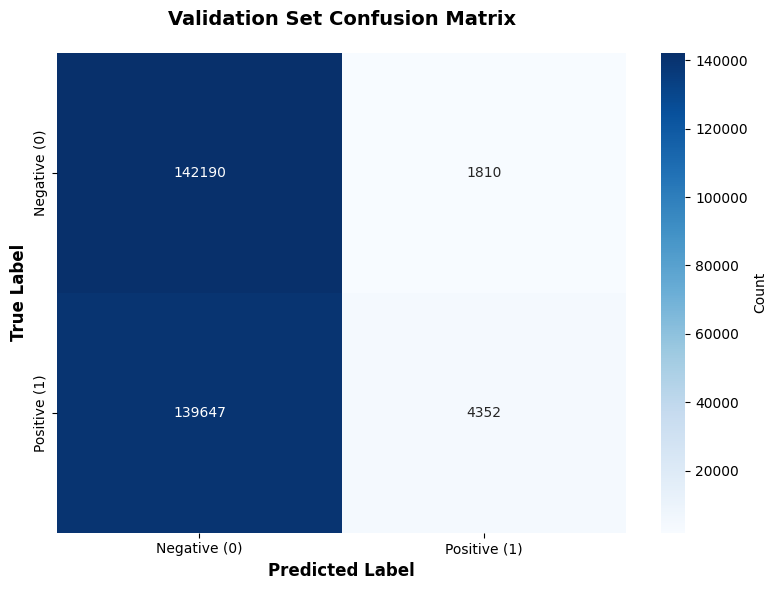


Confusion Matrix Summary:
True Negatives (TN):  142190  - Correctly predicted 0
False Positives (FP):   1810  - Predicted 1 but actual was 0
False Negatives (FN):  139647  - Predicted 0 but actual was 1
True Positives (TP):    4352  - Correctly predicted 1
Total samples: 287999

✅ Results saved to: results/lstm_val_metrics.json

COMPUTATIONAL REQUIREMENTS
Number of trainable parameters: 15,534,338
Training time: 29s (29.22 seconds)
Validation Accuracy: 50.88%
Validation Metrics: {'accuracy': 50.882815565331825, 'precision_label_0': 0.5045114729435809, 'recall_label_0': 0.9874305555555556, 'f1_label_0': 0.6678142106017091, 'precision_label_4': 0.706264199935086, 'recall_label_4': 0.030222432100222917, 'f1_label_4': 0.05796445148873542, 'roc_auc_score': 0.508315521191891, 'confusion_matrix': array([[142190,   1810],
       [139647,   4352]]), 'num_trainable_parameters': 15534338, 'training_time_seconds': 29.22031593322754}


In [69]:
# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load("lstm_best_model.pth", map_location=device))
model.to(device)

# After training, evaluate on validation set (with confusion matrix plot)
val_metrics = evaluate_model(
    model, 
    device, 
    val_loader,
    label_0,
    label_4,
    plot_confusion_matrix=True,
    title="Validation Set Confusion Matrix",
    training_time_seconds=training_time,
    model_name="lstm",
    dataset_split="val",
    save_results=True,
)

print(f"Validation Accuracy: {val_metrics['accuracy']:.2f}%")
print(f"Validation Metrics: {val_metrics}")



##  Test Sets


✅ Results saved to: results/lstm_test_metrics.json

COMPUTATIONAL REQUIREMENTS
Number of trainable parameters: 15,534,338
Training time: 29s (29.22 seconds)
Test Accuracy: 50.89%


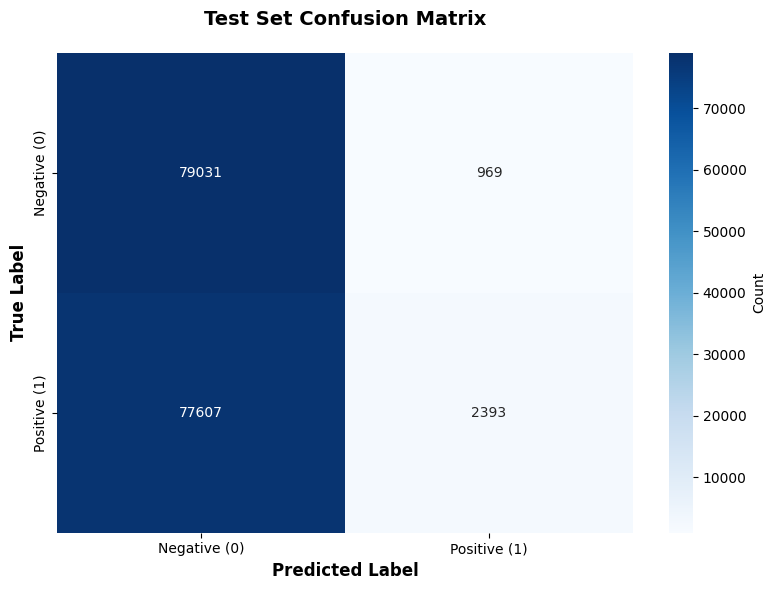


Confusion Matrix Summary:
True Negatives (TN):   79031  - Correctly predicted 0
False Positives (FP):    969  - Predicted 1 but actual was 0
False Negatives (FN):   77607  - Predicted 0 but actual was 1
True Positives (TP):    2393  - Correctly predicted 1
Total samples: 160000

✅ Results saved to: results/lstm_test_metrics.json

COMPUTATIONAL REQUIREMENTS
Number of trainable parameters: 15,534,338
Training time: 29s (29.22 seconds)


In [ ]:

# Or plot test confusion matrix separately
test_metrics = evaluate_model(
    model, 
    device, 
    test_loader,
    label_0,
    label_4,
    plot_confusion_matrix=True,
    title="Test Set Confusion Matrix",
    training_time_seconds=training_time,
    num_trainable_parameters=num_trainable_params,
    model_name="lstm",
    dataset_split="test",
    save_results=True,
)
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
